In [400]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

renewables_csv = 'renewable-share-energy.csv'
co2_csv = 'consumption-co2-per-capita.csv'
gdp_file = "world_bank_GDP_per_country.csv"
country_code_names_csv = 'country_code_names.csv'

# Global code

In [401]:
country_code_names = pd.read_csv(country_code_names_csv, index_col=0)

In [402]:
country_name = "Country Name"

In [403]:
display(country_code_names.loc['ZAF', country_name])

'South Africa'

# functions to turn the CSV files into Pandas dataframes

In [404]:
# functions to turn the CSV files into Pandas dataframes

def vertical_to_horizontal(csv_file):
    # Read the CSV file into a DataFrame
    dataframe = pd.read_csv(csv_file)

    # Pivot the DataFrame based on 'Entity' column
    pivoted_df = dataframe.pivot_table(index='Year', columns='Code', values=dataframe.columns[3]).reset_index()
    
    return pivoted_df

# flipping the data and removing unused years.

renewables_flipped = vertical_to_horizontal(renewables_csv)
renewables_flipped = renewables_flipped[(renewables_flipped['Year'] >= 1990) & (renewables_flipped['Year'] <= 2020)]

co2_flipped = vertical_to_horizontal(co2_csv)
co2_flipped = co2_flipped[(co2_flipped['Year'] >= 1990) & (co2_flipped['Year'] <= 2020)]

non_country_entities = [
    'High-income countries', 'South America', 'Europe', 'Oceania', 'Africa',
    'Lower-middle-income countries', 'Upper-middle-income countries', 'World',
    'North America', 'European Union (27)', 'Asia', 'OWID_WRL'
]

def filter_countries_1990_2020(df):
    # Filter the DataFrame to keep only rows for 1990 and 2020
    df_1990 = df[df['Year'] == 1990]
    df_2020 = df[df['Year'] == 2020]

    # Extract the countries that have data in both 1990 and 2020
    countries_1990 = set(df_1990.columns[df_1990.notnull().any()])
    countries_2020 = set(df_2020.columns[df_2020.notnull().any()])

    countries_both_years = list(countries_1990.intersection(countries_2020))

    # Filter the original DataFrame to include only columns (countries) present in both 1990 and 2020
    filtered_df = df[df.columns[df.columns.isin(countries_both_years)]]

    return filtered_df

renewables_flipped = filter_countries_1990_2020(renewables_flipped)
co2_flipped = filter_countries_1990_2020(co2_flipped)

def filter_common_countries(df1, df2):
    countries_df1 = set(df1.columns)
    countries_df2 = set(df2.columns)
    common_countries = list(countries_df1.intersection(countries_df2))

    # Exclude 'Year' from removal if present in common columns
    if 'Year' in common_countries:
        common_countries.remove('Year')

    # Filter DataFrames to include only common countries (excluding 'Year')
    filtered_df1 = df1[['Year'] + common_countries]
    filtered_df2 = df2[['Year'] + common_countries]

    return filtered_df1, filtered_df2

renewables_filtered, co2_filtered = filter_common_countries(renewables_flipped, co2_flipped)

# Remove non-country entities from the DataFrames
renewables_filtered = renewables_filtered.drop(columns=non_country_entities, errors='ignore')
renewables_filtered.set_index('Year', inplace=True)
renewables_filtered.interpolate(method='linear')

co2_filtered = co2_filtered.drop(columns=non_country_entities, errors='ignore')
co2_filtered.set_index('Year', inplace=True)
co2_filtered = co2_filtered.interpolate(method='linear')

display(renewables_filtered.head(3))
display(co2_filtered.head(3))


Code       UKR       EGY        TUR       AUS       CHN        ARG        BRA  \
Year                                                                            
1990  0.973168  7.520866  12.219702  4.459392  4.723668  10.292410  44.531140   
1991  1.156305  7.396339  11.752680  4.740063  4.424779   9.080978  45.268887   
1992  0.921140  7.380687  13.079588  4.731717  4.412703  10.206500  45.736390   

Code       IRL       GBR       SVK  ...        VEN       JPN       ROU  \
Year                                ...                                  
1990  1.748312  0.680118  2.238396  ...  18.119040  5.605646  4.590245   
1991  1.801310  0.610434  1.873833  ...  21.675652  5.917130  6.907993   
1992  1.975835  0.742499  2.679717  ...  21.255587  5.080176  6.283785   

Code        HRV       MAR       BEL       ISR       BLR        COL       IDN  
Year                                                                          
1990  11.523735  4.359246  0.274797  0.006869  0.012692  32.548810  3.731863  
1991  19.537254  4.325900  0.257478  0.013515  0.011449  31.965420  3.812470  
1992  15.994586  3.039623  0.294191  0.055975  0.012469  24.941273  4.408543  

[3 rows x 60 columns]

Code       UKR       EGY       TUR        AUS       CHN       ARG       BRA  \
Year                                                                          
1990  9.703509  1.431379  3.970047  14.263723  2.011824  3.432985  1.629641   
1991  8.813906  1.336157  3.868271  14.118852  2.051064  3.639913  1.644316   
1992  8.487364  1.456119  4.437934  14.113060  2.177177  3.805473  1.630011   

Code        IRL        GBR        SVK  ...       VEN        JPN       ROU  \
Year                                   ...                                  
1990  11.350045  11.696713  13.914664  ...  4.762998  10.653232  7.047411   
1991  11.799738  11.793274  10.875343  ...  4.826739  10.770959  5.684372   
1992  12.238233  12.046045  10.595663  ...  4.589158  11.439899  5.267738   

Code       HRV       MAR        BEL        ISR       BLR       COL       IDN  
Year                                                                          
1990  4.303235  1.240285  15.542700  10.324067  5.879944  1.900071  0.766681  
1991  3.223149  1.231995  15.582521  10.146182  6.373846  1.816593  0.869577  
1992  3.786203  1.409892  17.213676  11.444240  4.293134  1.982240  0.984626  

[3 rows x 60 columns]

In [405]:
def gdp_dataframe(directory):
    dataframe = pd.read_csv(directory, header=0, index_col=0)

    transposed_df = dataframe.transpose()
    transposed_df.index.name = 'Year'

    return transposed_df

In [406]:
gdp_filtered = gdp_dataframe(gdp_file)
gdp_filtered = gdp_filtered.interpolate(method='linear')

# CO2 / GDP per capita functions

In [407]:
def divide_dataframes(df1, df2):
    common_columns = df1.columns.intersection(df2.columns)
    divided_df = pd.DataFrame()

    for col in common_columns:
        divided_df[col] = df1[col] / df2[col].values

    return divided_df

# Plotting individual country Renewables and Per capita consumption-based CO2 emissions over time

In [408]:
def plot_dataframes(df1, df2):
    # Assuming the columns in df1 and df2 are aligned (same columns in both DataFrames)
    columns = df1.columns.intersection(df2.columns)

    for column in columns:
        fig, ax1 = plt.subplots(figsize=(8, 5))

        ax1.plot(df1.index, df1[column], marker='o', color='tab:blue')
        ax1.set_xlabel('Year')
        ax1.set_ylabel(f'Renewables (% equivalent primary energy)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.grid(True)

        ax2 = ax1.twinx()
        ax2.plot(df2.index, df2[column], marker='o', color='tab:green')
        ax2.set_ylabel(f'Per capita consumption-based CO2 emissions', color='tab:green')
        ax2.tick_params(axis='y', labelcolor='tab:green')

        plt.title(f'Renewables and Per capita consumption-based CO2 emissions over time ({country_code_names.loc[column, country_name]})')
        plt.show()

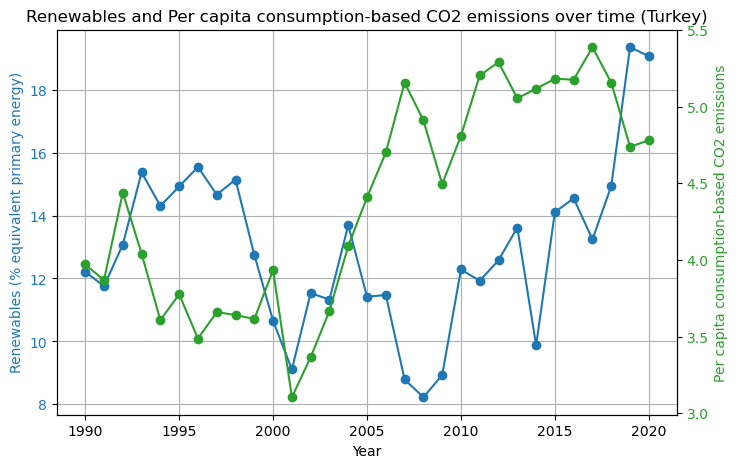

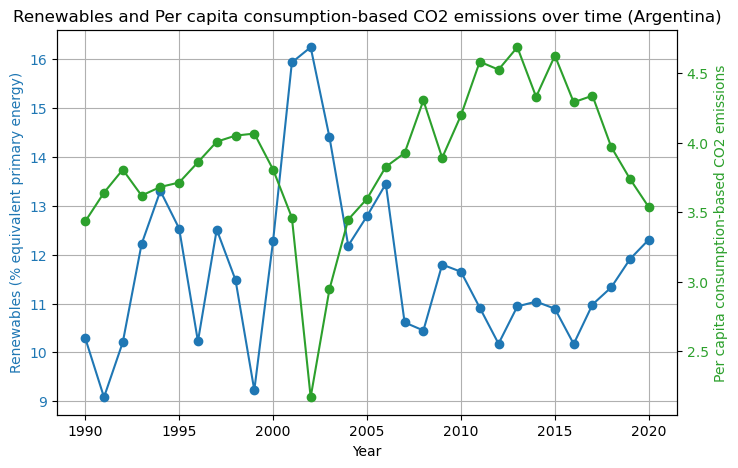

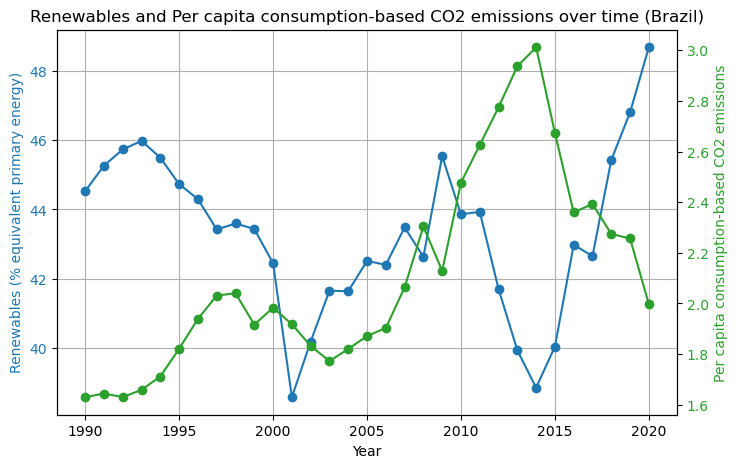

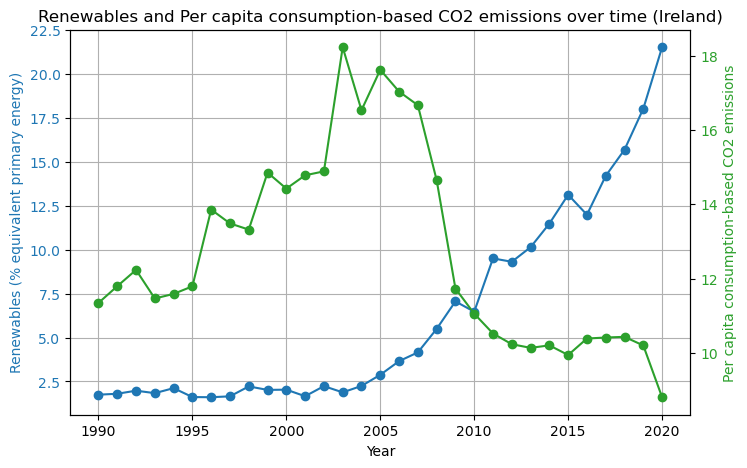

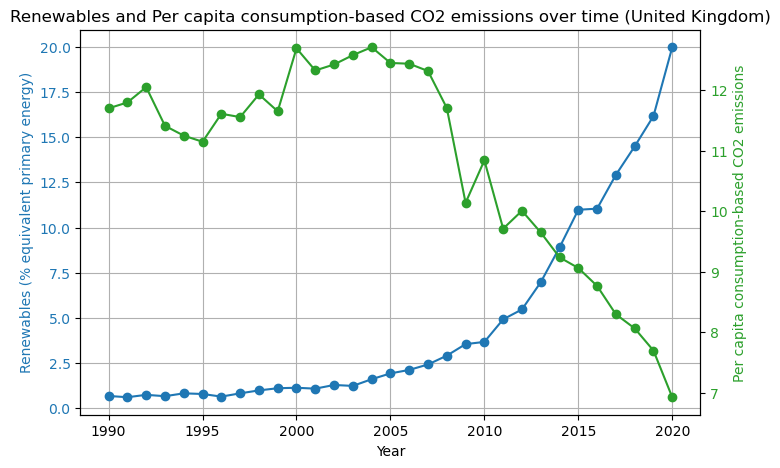

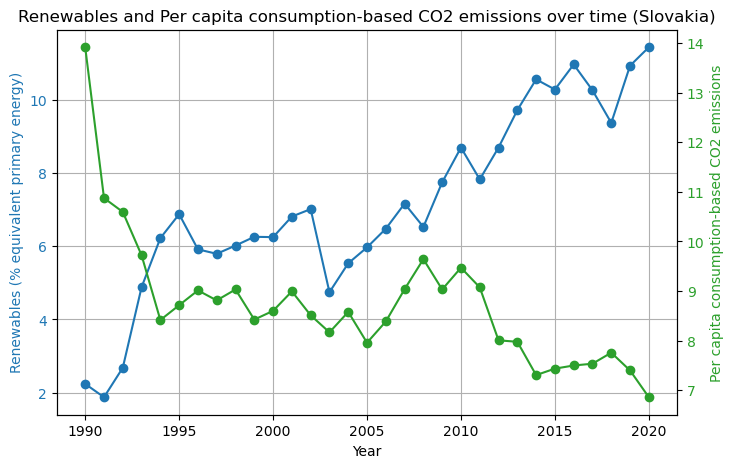

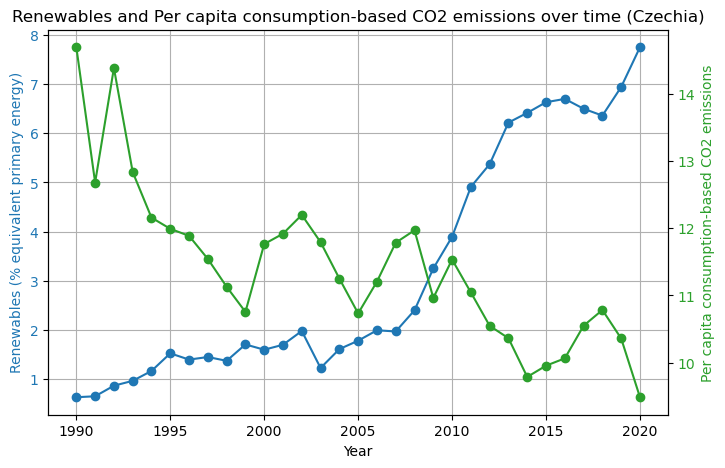

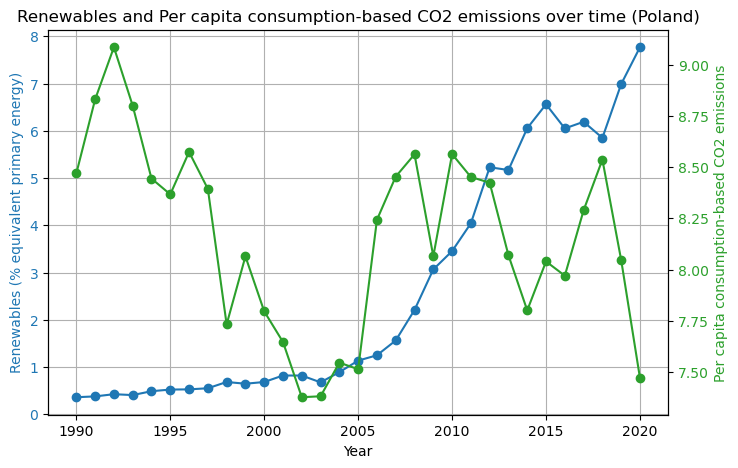

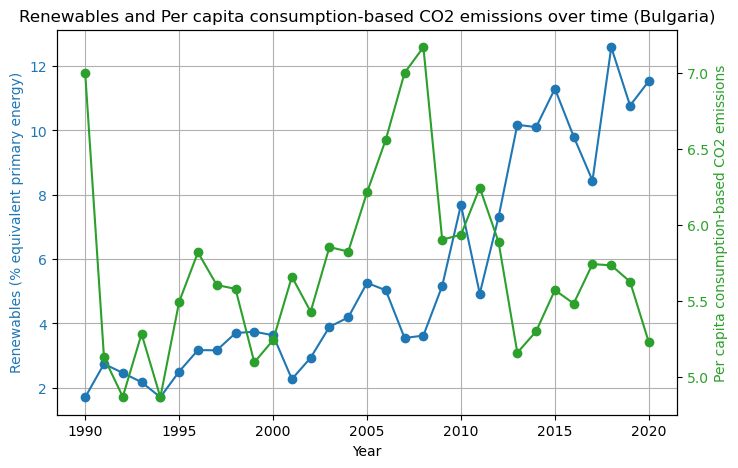

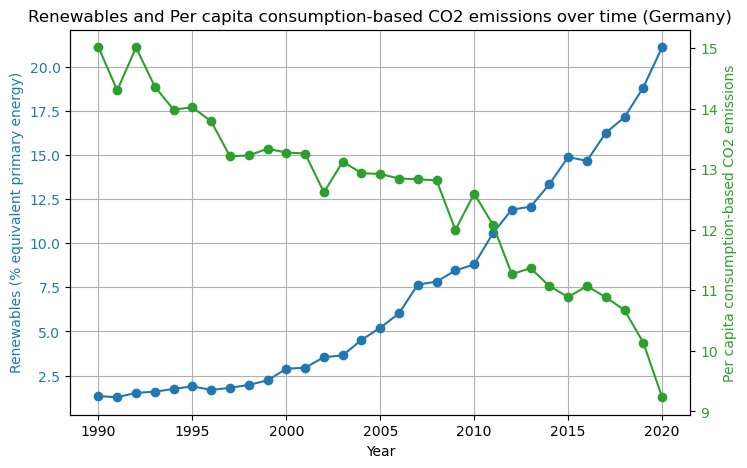

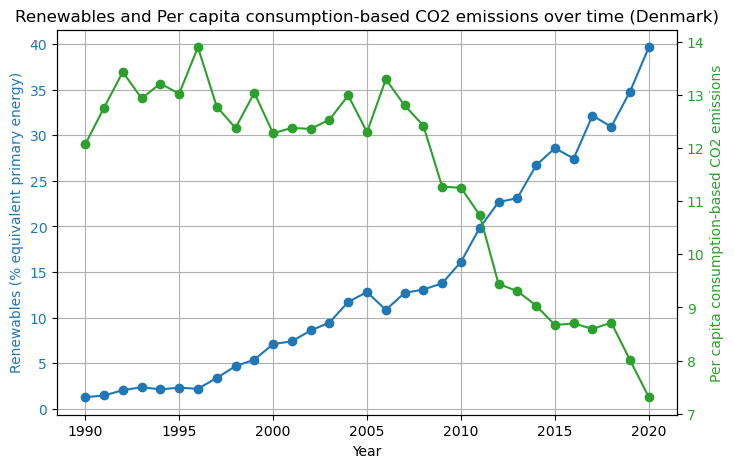

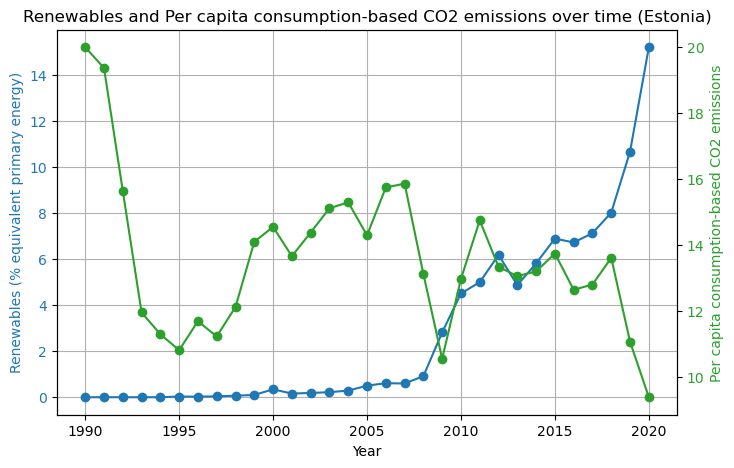

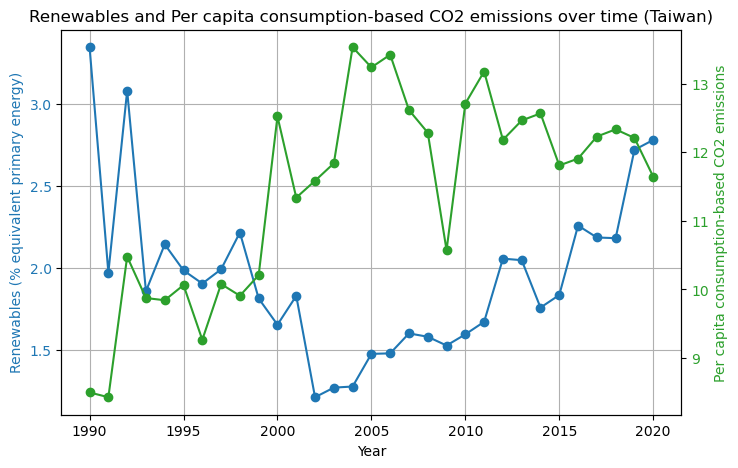

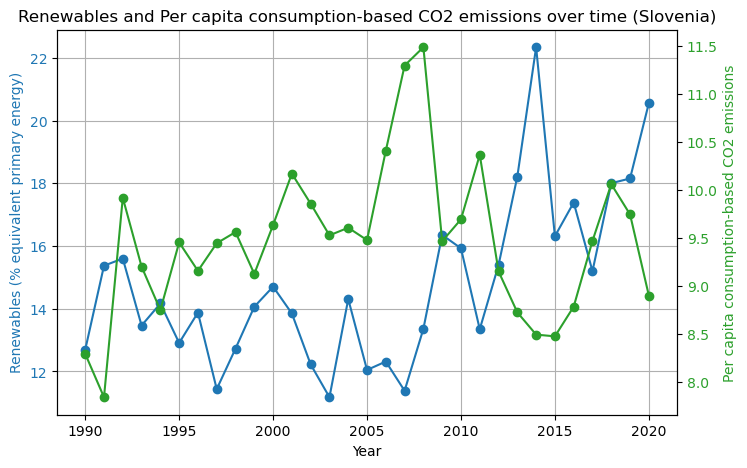

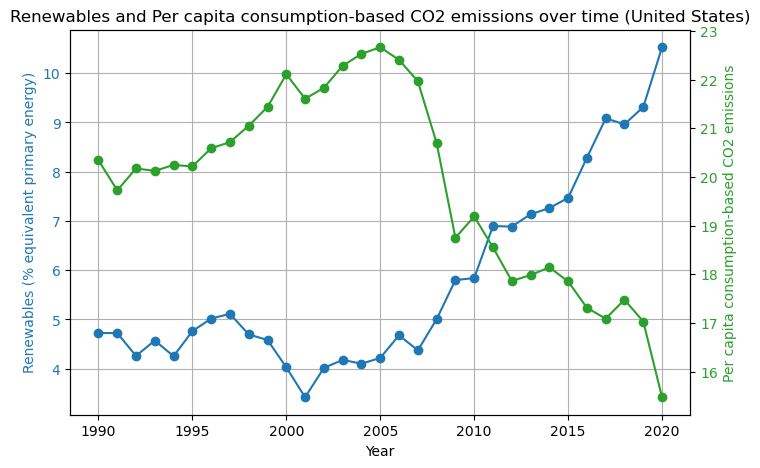

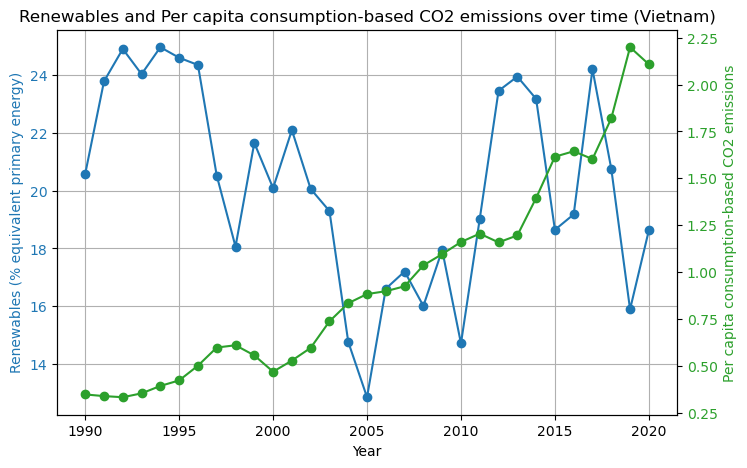

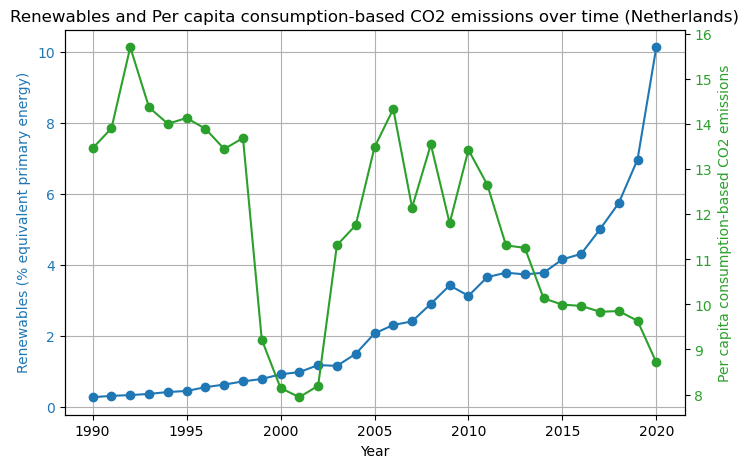

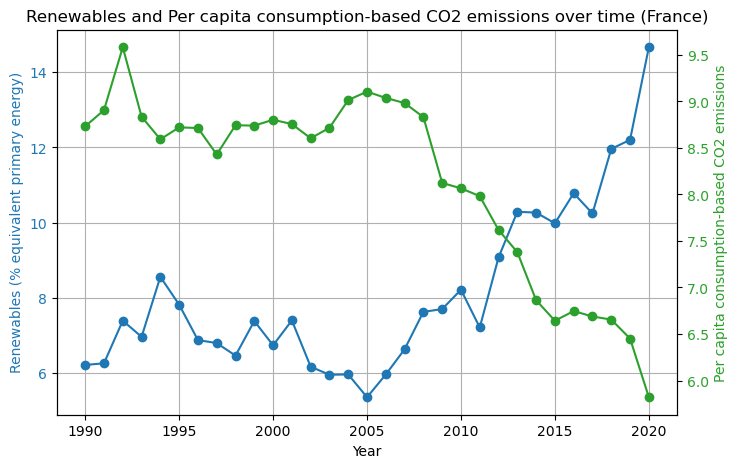

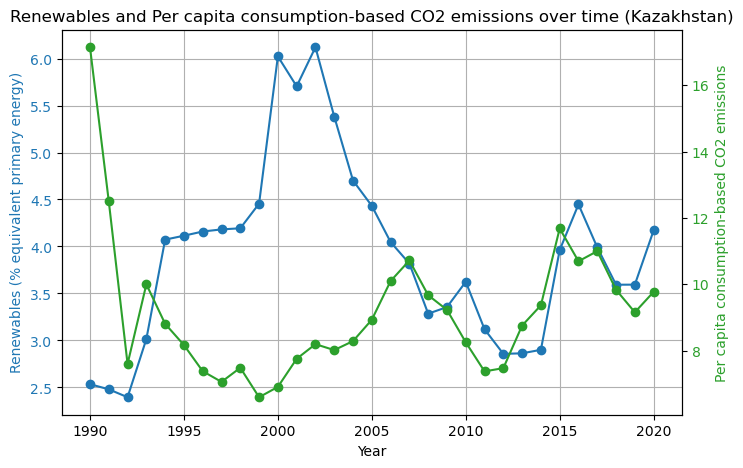

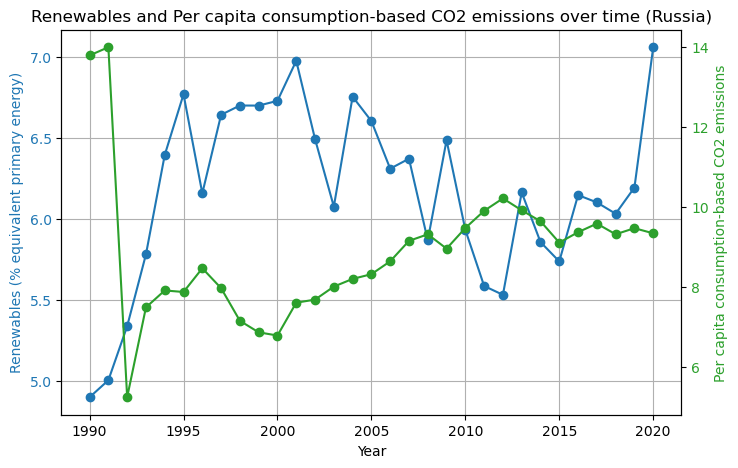

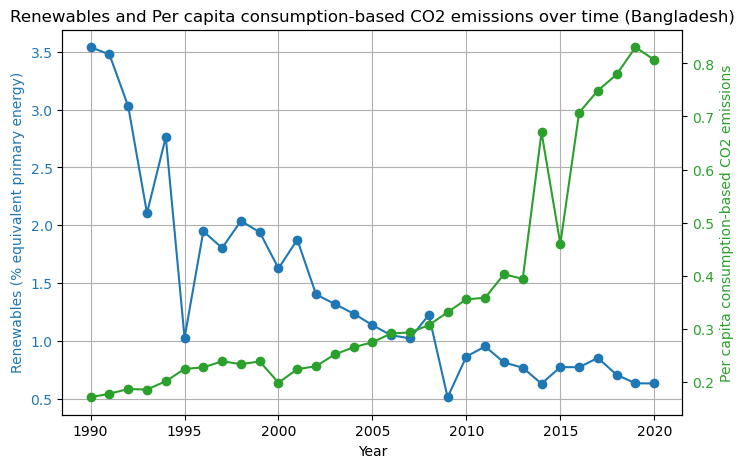

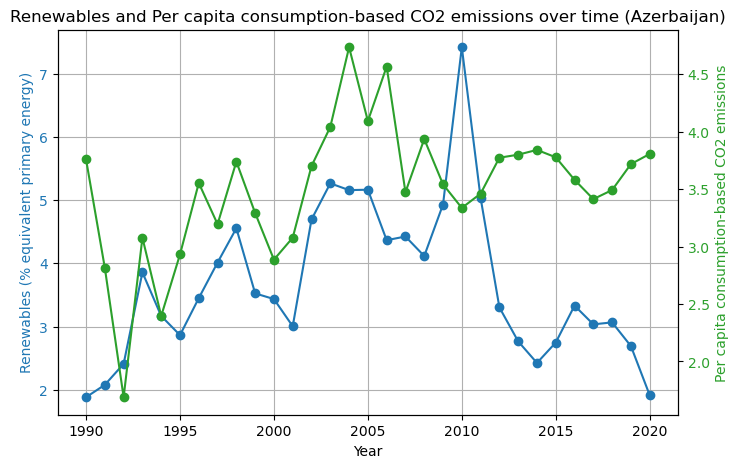

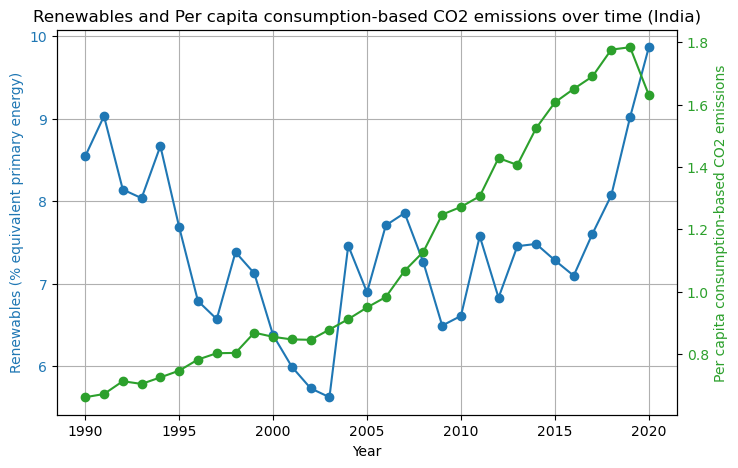

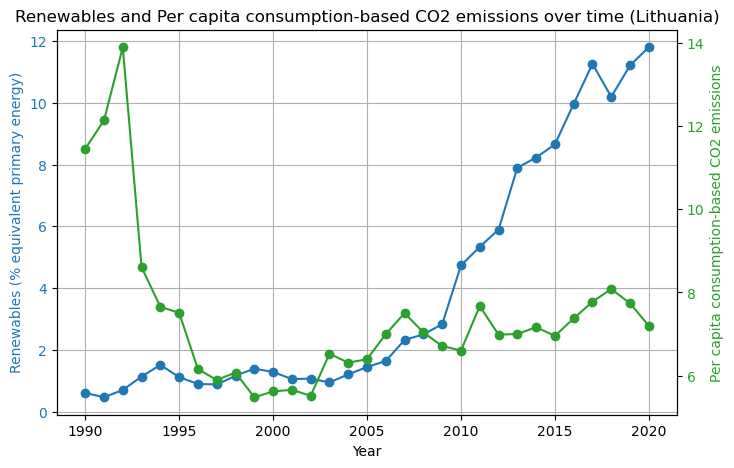

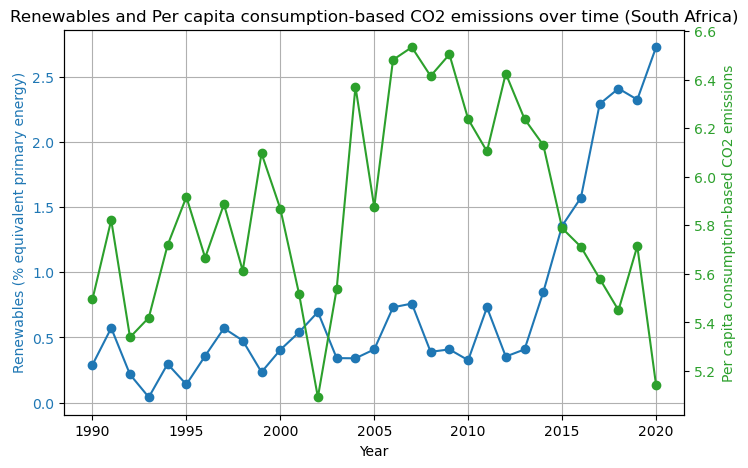

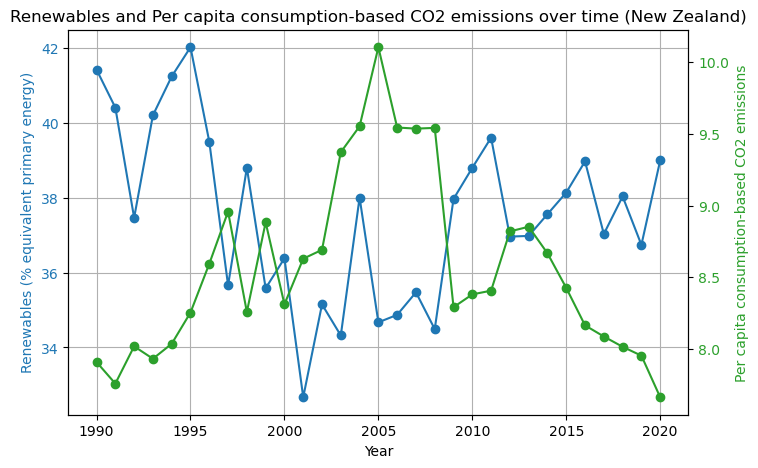

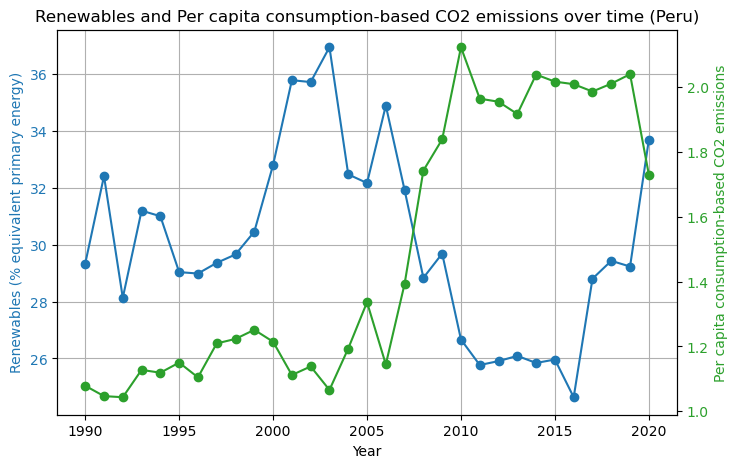

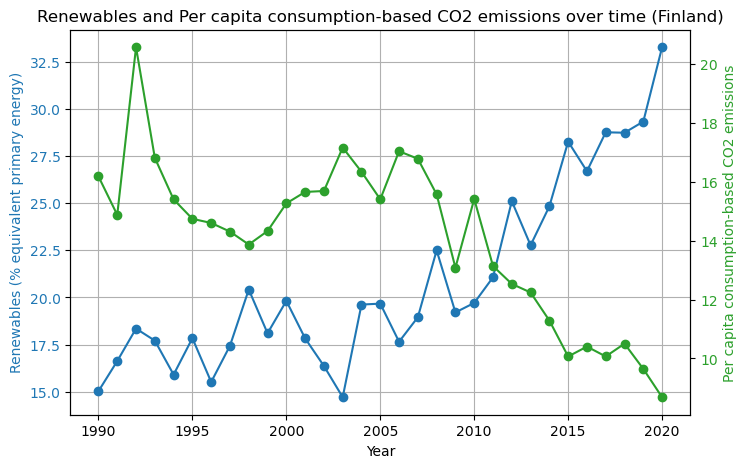

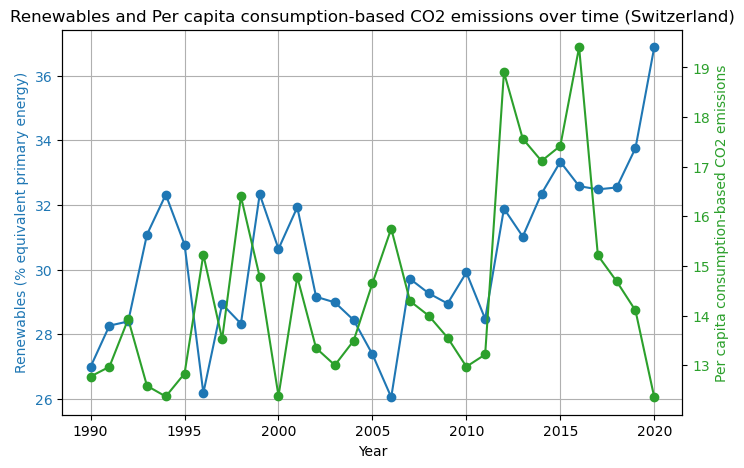

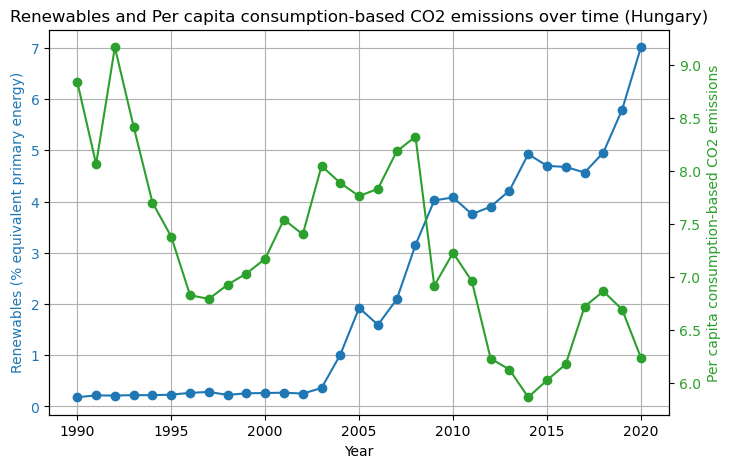

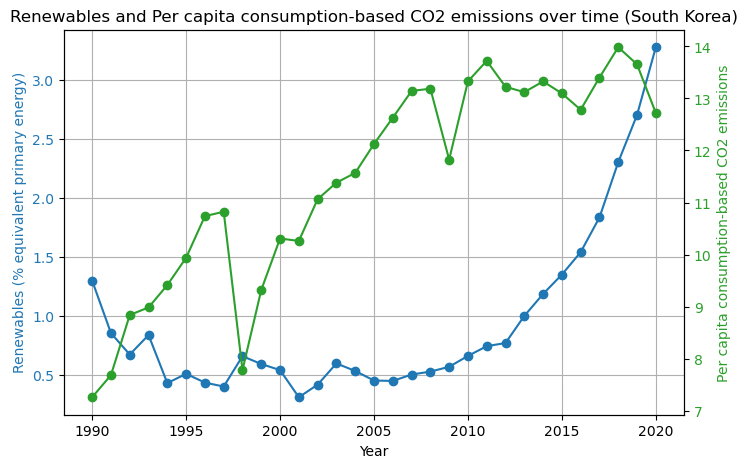

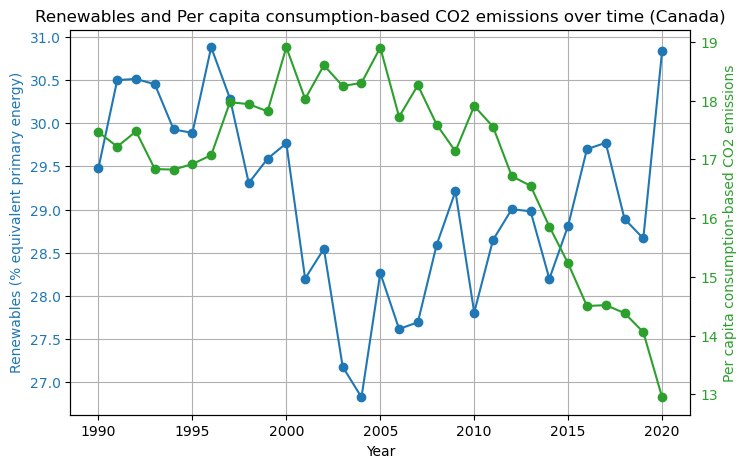

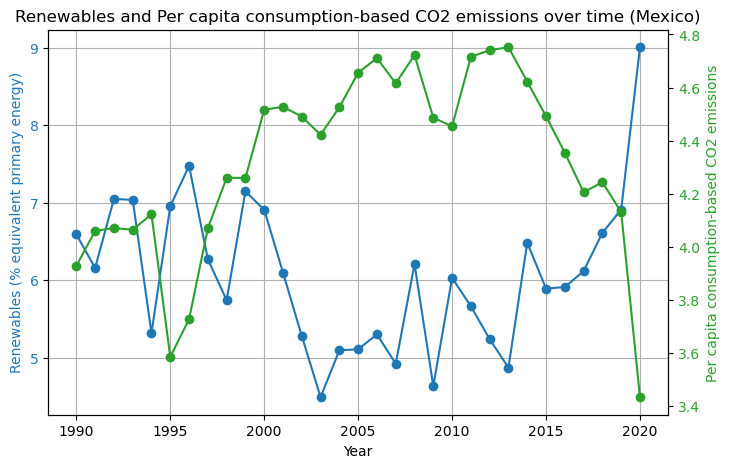

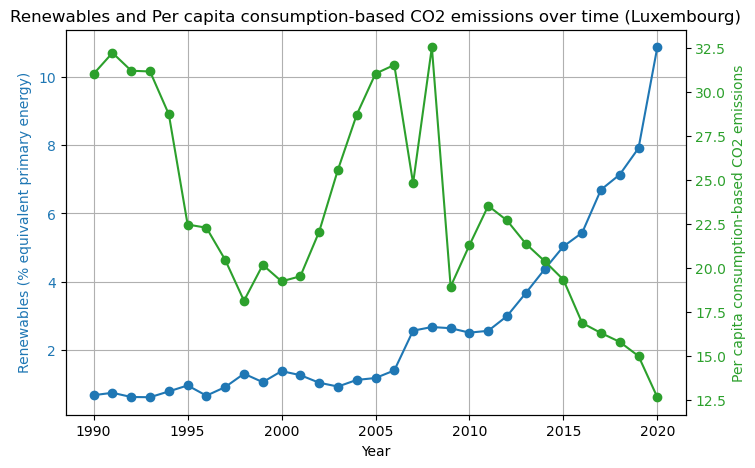

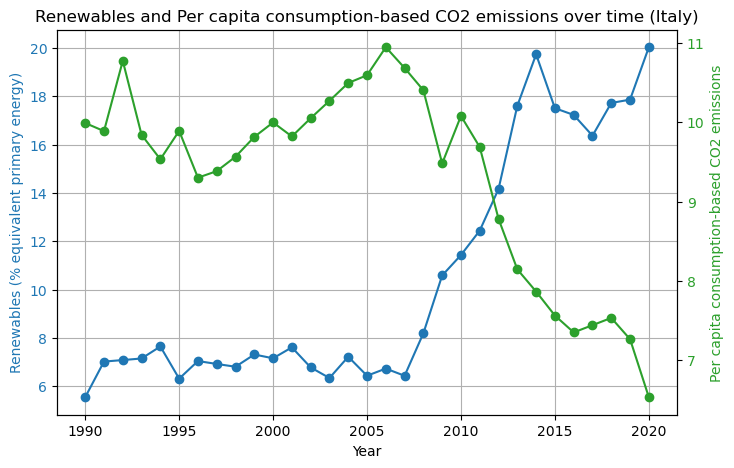

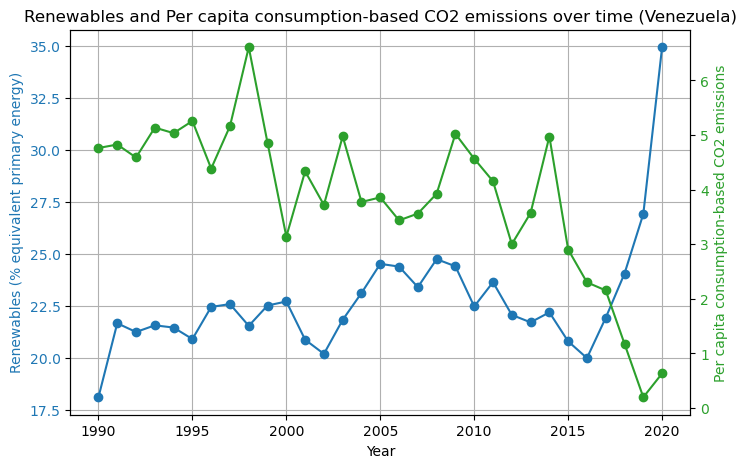

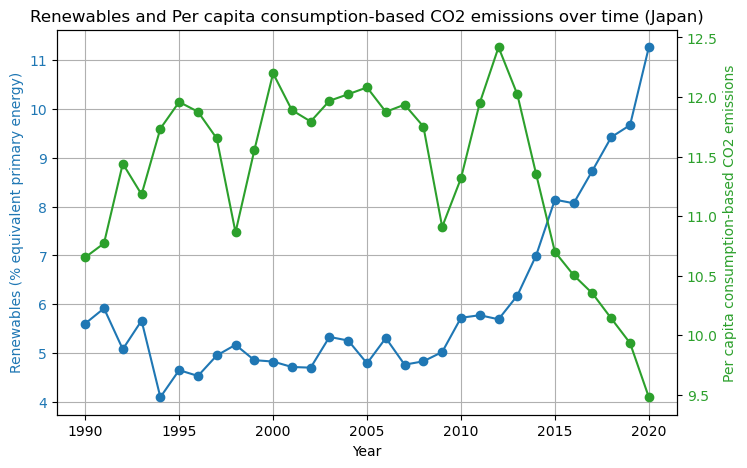

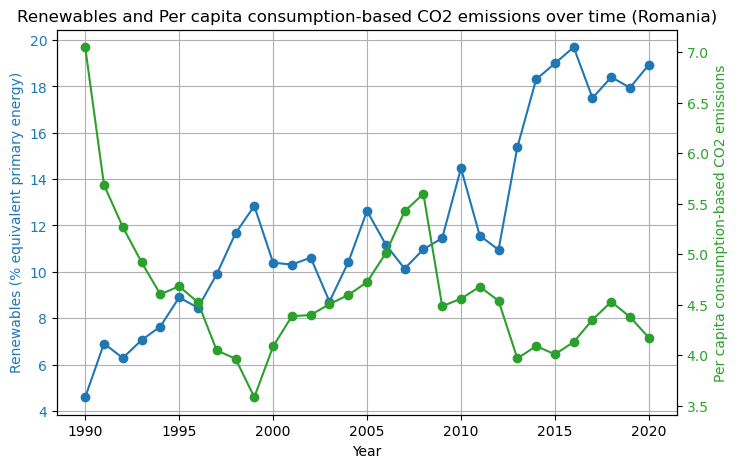

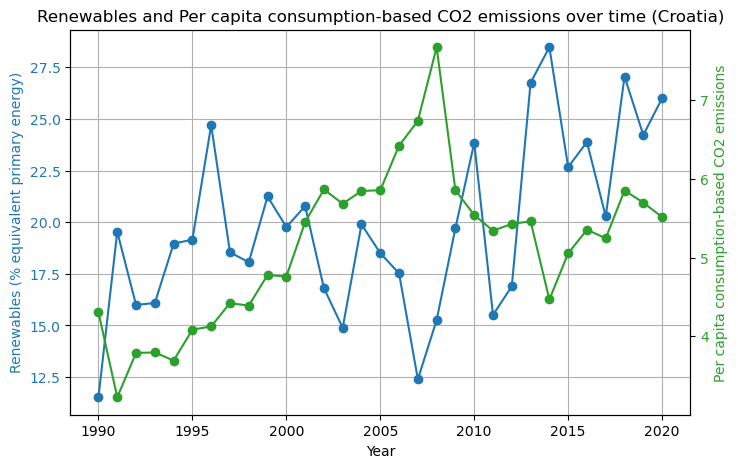

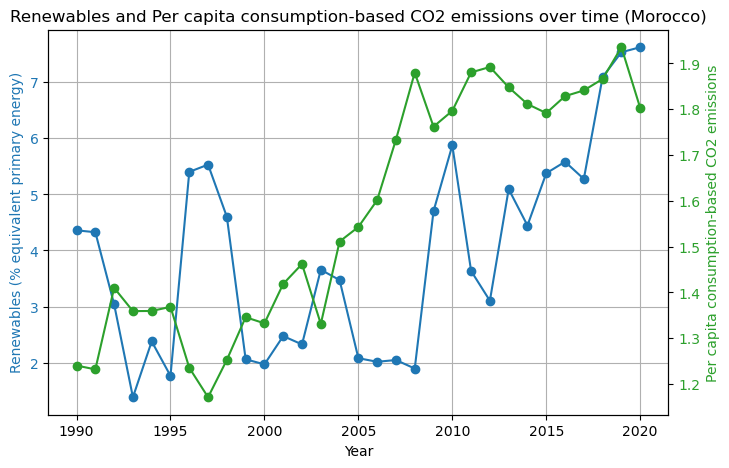

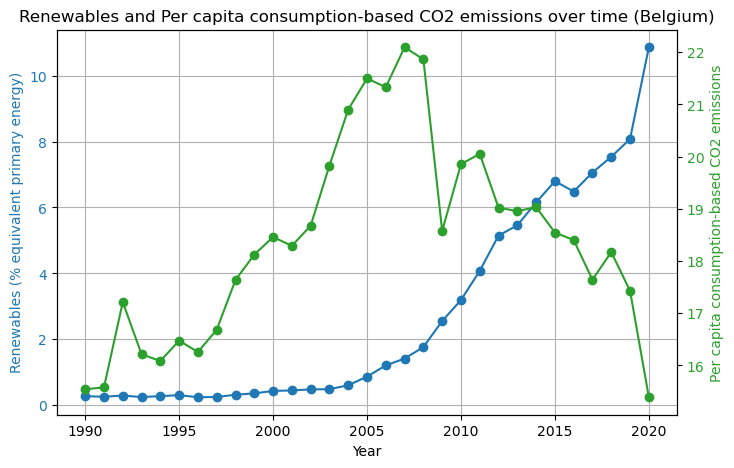

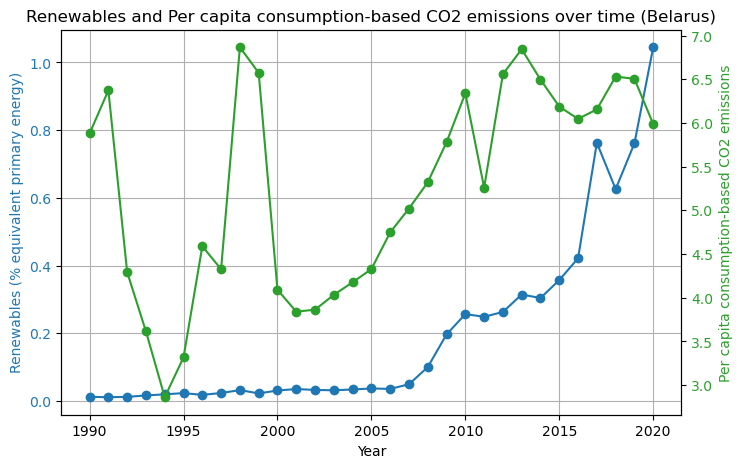

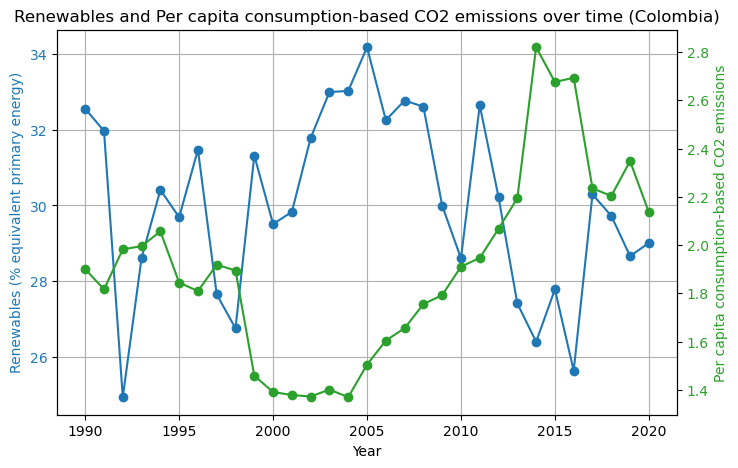

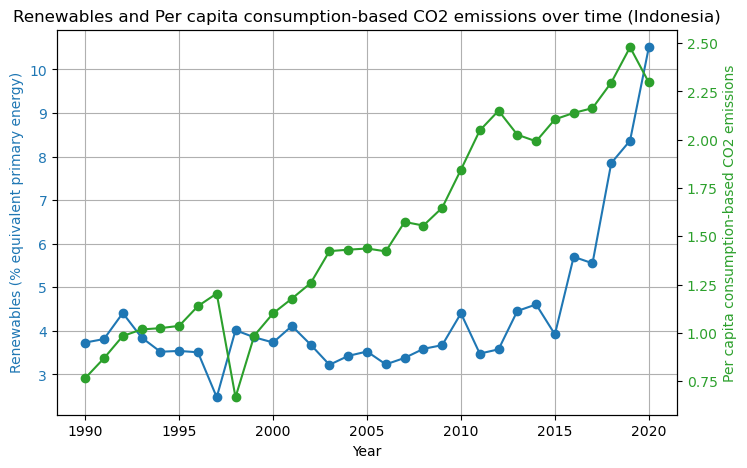

In [409]:
plot_dataframes(renewables_filtered, co2_filtered)

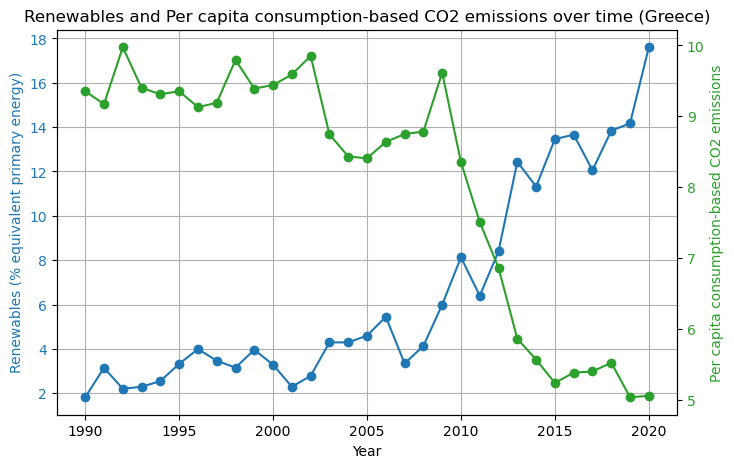

In [410]:
# How to plot one country
plot_dataframes(pd.DataFrame(renewables_filtered['GRC']), pd.DataFrame(co2_filtered['GRC']))

# Calculating Pearson correlation coefficients

In [411]:
def calculate_correlation(df1, df2):
    # Assuming the columns in df1 and df2 are aligned (same columns in both DataFrames)
    columns = df1.columns.intersection(df2.columns)
    correlations = {'Country Code': [], 'Correlation': [], 'P-Value': []}

    for column in columns:
        correlation, p_value = pearsonr(df1[column], df2[column])
        correlations['Country Code'].append(column)
        correlations['Correlation'].append(correlation)
        correlations['P-Value'].append(p_value)

    correlation_df = pd.DataFrame(correlations)
    return correlation_df

In [412]:
def plot_correlation_bars(correlation_df, plot_title):
    correlation_df_sorted = correlation_df.sort_values(by='Correlation')

    # Splitting into positive and negative values
    positive_corr = correlation_df_sorted[correlation_df_sorted['Correlation'] >= 0]
    negative_corr = correlation_df_sorted[correlation_df_sorted['Correlation'] < 0]

    plt.figure(figsize=(13, 7))

    # Plotting negative values with custom color (red)
    plt.bar(negative_corr['Country Code'], negative_corr['Correlation'], color='tab:red')
    # Plotting positive values with custom color (blue)
    plt.bar(positive_corr['Country Code'], positive_corr['Correlation'], color='tab:blue')

    # Plotting error bars with p-values
    plt.errorbar(
        x=correlation_df_sorted['Country Code'],
        y=correlation_df_sorted['Correlation'],
        yerr=correlation_df_sorted['P-Value'],
        fmt='none',
        capsize=3,
        ecolor='black',
    )

    plt.title(plot_title)
    plt.xlabel('Country Code')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45, ha='center')  # Centering the tick labels
    plt.legend(['Negative Correlation', 'Positive Correlation'], loc='upper right')

    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()

# Calculating Spearmans correlations

In [413]:
def calculate_spearmans_correlation(df1, df2):
    # Assuming the columns in df1 and df2 are aligned (same columns in both DataFrames)
    columns = df1.columns.intersection(df2.columns)
    correlations = {'Country Code': [], 'Correlation': [], 'P-Value': []}

    for column in columns:
        correlation, p_value = spearmanr(df1[column], df2[column])
        correlations['Country Code'].append(column)
        correlations['Correlation'].append(correlation)
        correlations['P-Value'].append(p_value)

    correlation_df = pd.DataFrame(correlations)
    return correlation_df

# LRM tests

In [414]:
def lrm_test(df1, df2):
    
    columns = df1.columns.intersection(df2.columns)
    results = {'Country Code': [], 'Intercept': [], 'Slope': [], 'P-Value': [], 'R-Squared': []}

    for column in columns:
        x = df1[column]
        y = df2[column]
        
        x = sm.add_constant(x)
        # Fit the linear regression model
        model = sm.OLS(y, x).fit()

        #results
        intercept = model.params[0]
        slope = model.params[1]
        p_value = model.pvalues[1]
        r_squared = model.rsquared

        results['Country Code'].append(column)
        results['Intercept'].append(intercept)
        results['Slope'].append(slope)
        results['P-Value'].append(p_value)
        results['R-Squared'].append(r_squared)
    
    results_df = pd.DataFrame(results)
    return results_df

In [415]:
def plot_slopes(results_df):
    df_sorted = results_df.sort_values(by='R-Squared')
    plt.figure(figsize=(10, 4))
    plt.bar(df_sorted['Country Code'], df_sorted['R-Squared'], color='skyblue')

    for index, row in df_sorted.iterrows():
        plt.text(row['Country Code'], 0, country_code_names.loc[row["Country Code"], country_name], ha='center', va='bottom', rotation=90)

    plt.ylim(0, 1)
    plt.xlabel('Column')
    plt.ylabel('Slope')
    plt.title('R-Squared values of Linear Regressions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Granger causality test

In [416]:
# Function to perform Granger causality test for each pair of corresponding columns from two DataFrames
def granger_causality_test_between_dfs(df1, df2, maxlag):
    results = []
    columns = df1.columns.intersection(df2.columns)
    
    for col in columns:

        combined_df = pd.concat([df1[col], df2[col]], axis=1)

        test_result = grangercausalitytests(combined_df, maxlag=maxlag)

        # Extracting F-test statistics and p-values from the test results
        f_statistics = [test_result[i+1][0]['ssr_ftest'][0] for i in range(maxlag)]
        p_values = [round(test_result[i+1][0]['ssr_ftest'][1], 4) for i in range(maxlag)]
        

        result_dict = {'Country Code': col}
        
        for lag in range(maxlag):
            result_dict[f'F_Test_Statistic_{lag+1}'] = f_statistics[lag]
            result_dict[f'P_Value_{lag+1}'] = p_values[lag]

        results.append(result_dict)
        
        print('-'*50)

    result_df = pd.DataFrame(results)
    return result_df

In [417]:
def plot_granger_results(df):
    # Sort DataFrame by 'F_Test_Statistic_1'
    sorted_df = df.sort_values(by='F_Test_Statistic_1', ascending=False)
    
    fig, ax = plt.subplots(figsize=(13, 7))

    # Plotting F-Test Statistics
    bar_width = 0.3
    index = range(len(sorted_df))

    bar1 = ax.bar(index, sorted_df['F_Test_Statistic_1'], bar_width, label='F-Test Statistic 1 lag', color='skyblue')
    bar2 = ax.bar([i + bar_width for i in index], sorted_df['F_Test_Statistic_2'], bar_width, label='F-Test Statistic 2 lag', color='orange')

    ax.set_xlabel('Countries')
    ax.set_ylabel('F-Test Statistics')
    ax.set_title('Granger Causality: F-Test Statistics')
    ax.set_xticks([i + bar_width / 2 for i in index])

    country_names = [country_code_names.loc[code, 'Country Name'] if code in country_code_names.index else code for code in sorted_df['Country Code']]
    ax.set_xticklabels(country_names, rotation=90)
    ax.legend()

    # Displaying p-values as error bars
    ax.errorbar(index, sorted_df['F_Test_Statistic_1'], yerr=sorted_df['P_Value_1'], fmt='none', capsize=3, label='P-Value 1', color='black')
    ax.errorbar([i + bar_width for i in index], sorted_df['F_Test_Statistic_2'], yerr=sorted_df['P_Value_2'], fmt='none', capsize=3, label='P-Value 2', color='black')

    plt.tight_layout()
    plt.show()

# ARIMA Forecast (does not make sense to use)

In [418]:
def arima_forecast(df, steps):
    forecast_results = {}
    for column in df.columns:
        # Fit ARIMA model for each column
        model = ARIMA(df[column], order=(5, 1, 0))  # Example order (p, d, q)
        model_fit = model.fit()

        # Make forecast for 'steps' number of future steps
        forecast = model_fit.forecast(steps=steps)

        # Store forecasted values in a dictionary
        forecast_results[column] = forecast

    # Create a DataFrame from forecast_results dictionary
    forecast_df = pd.DataFrame(forecast_results,)
    forecast_df.index = range(2021, 2030 + 1, 1)

    concat_df = pd.concat([df, forecast_df], axis=0)
    concat_df.index.name = "Year"
    
    return concat_df

In [419]:
#renewables_forecast = arima_forecast(renewables_filtered, 10)
#co2_forecast = arima_forecast(detrended_co2_filtered, 10)

#plot_dataframes(renewables_forecast, co2_forecast)

# Test Runtime code functions. Non-adjusted and GDP adjusted

In [420]:
def run_tests(renewables_filtered, co2_filtered):
    plot_dataframes(pd.DataFrame(renewables_filtered['GRC']), pd.DataFrame(co2_filtered['GRC']))
    plot_dataframes(pd.DataFrame(renewables_filtered['RUS']), pd.DataFrame(co2_filtered['RUS']))

    # run Pearson correlation
    pearson_cor_coeficient_per_capita = calculate_correlation(renewables_filtered, co2_filtered)
    # plotting correlation bars by country
    plot_correlation_bars(pearson_cor_coeficient_per_capita, 'Pearson Correlation Coefficients (Sorted)')

    # run Spearman correlation and plot
    spearmans = calculate_spearmans_correlation(renewables_filtered, co2_filtered)
    plot_correlation_bars(spearmans, 'Spearman Correlation Coefficients (Sorted)')

    # run LRM tests
    lrm_results = lrm_test(renewables_filtered, co2_filtered)
    plot_slopes(lrm_results)

    # run Granger causality tests
    granger_results_between_dfs = granger_causality_test_between_dfs(renewables_filtered, co2_filtered, 2)
    plot_granger_results(granger_results_between_dfs)
    

In [421]:
def run_tests_gdp_adjusted(renewables_filtered, co2_filtered, gdp_filtered):
    # creating the tests for GDP adjusted CO2 per capita data
    co2_gdp_adjusted = divide_dataframes(co2_filtered, (gdp_filtered / 10000000000))
    co2_gdp_adjusted = co2_gdp_adjusted.fillna(method='bfill')

    plot_dataframes(pd.DataFrame(renewables_filtered['GRC']), pd.DataFrame(co2_gdp_adjusted['GRC']))
    plot_dataframes(pd.DataFrame(renewables_filtered['RUS']), pd.DataFrame(co2_gdp_adjusted['RUS']))
    plot_dataframes(pd.DataFrame(renewables_filtered['NLD']), pd.DataFrame(co2_gdp_adjusted['NLD']))
    plot_dataframes(pd.DataFrame(renewables_filtered['ISR']), pd.DataFrame(co2_gdp_adjusted['ISR']))

    # run Pearson correlation
    pearson_cor_coeficient_per_capita = calculate_correlation(renewables_filtered, co2_gdp_adjusted)
    # plotting correlation bars by country
    plot_correlation_bars(pearson_cor_coeficient_per_capita, 'Pearson Correlation Coefficients GDP adjusted (Sorted)')

    # run Spearman correlation and plot
    spearmans = calculate_spearmans_correlation(renewables_filtered, co2_gdp_adjusted)
    plot_correlation_bars(spearmans, 'Spearman Correlation Coefficients GDP adjusted (Sorted)')

    # run LRM tests
    lrm_results = lrm_test(renewables_filtered, co2_gdp_adjusted)
    plot_slopes(lrm_results)

    # run Granger causality tests
    granger_results_between_dfs = granger_causality_test_between_dfs(renewables_filtered, co2_gdp_adjusted, 2)
    plot_granger_results(granger_results_between_dfs)

# Running tests without detrending

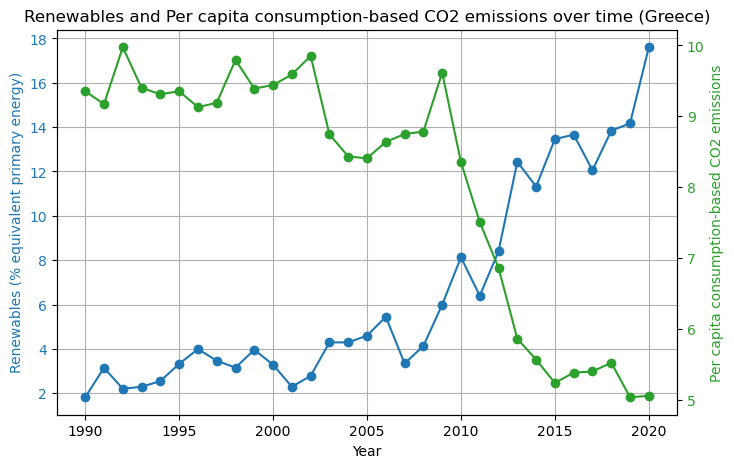

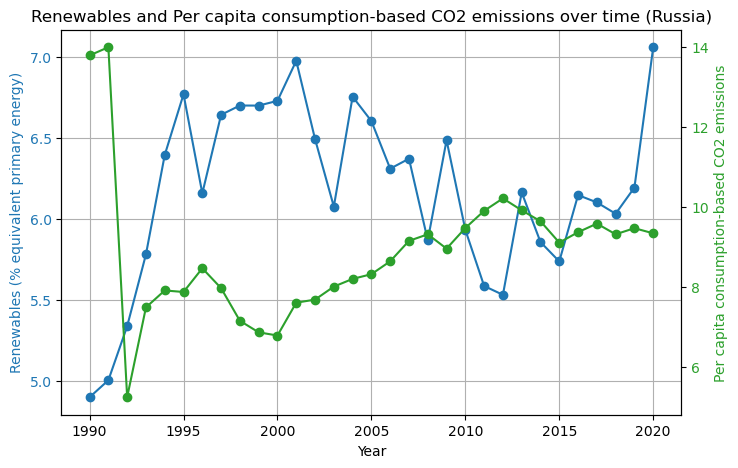

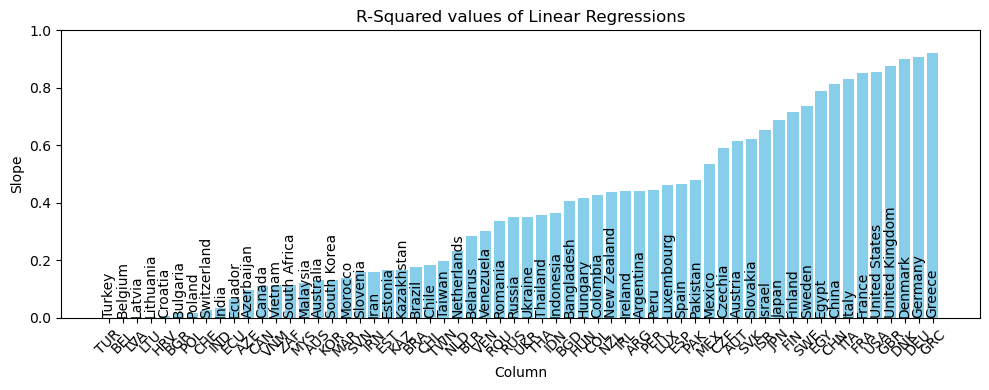


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2049  , p=0.6544  , df_denom=27, df_num=1
ssr based chi2 test:   chi2=0.2276  , p=0.6333  , df=1
likelihood ratio test: chi2=0.2268  , p=0.6339  , df=1
parameter F test:         F=0.2049  , p=0.6544  , df_denom=27, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1738  , p=0.8415  , df_denom=24, df_num=2
ssr based chi2 test:   chi2=0.4200  , p=0.8106  , df=2
likelihood ratio test: chi2=0.4170  , p=0.8118  , df=2
parameter F test:         F=0.1738  , p=0.8415  , df_denom=24, df_num=2
--------------------------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8054  , p=0.3774  , df_denom=27, df_num=1
ssr based chi2 test:   chi2=0.8949  , p=0.3441  , df=1
likelihood ratio test: chi2=0.8818  , p=0.3477  , df=1
parameter F test:         F=0.8054  , p=0.3774  , df_denom=27, df_num=1

Granger Causality
number of lags (no zero) 2
ssr

In [422]:
run_tests(renewables_filtered, co2_filtered)

# Running tests GDP adjusted without detrending

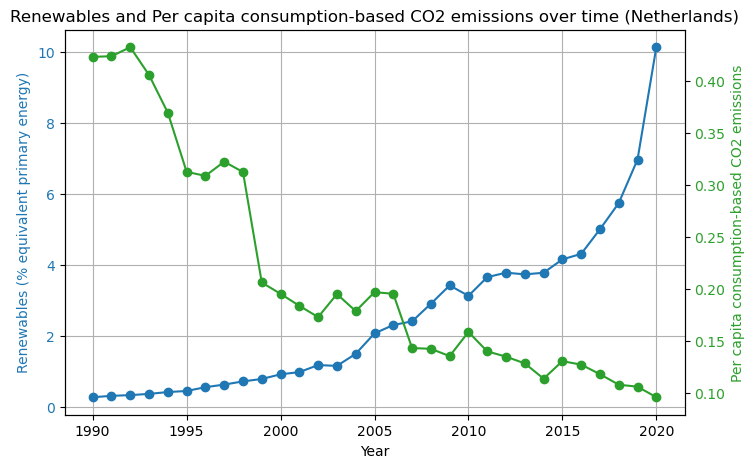

In [423]:
run_tests_gdp_adjusted(renewables_filtered, co2_filtered, gdp_filtered)

# Run tests with detrending

In [ ]:
def detrend_differencing(dataframe):
    detrended_dataframe = dataframe.copy()
    
    for column in dataframe.columns:
        detrended = detrended_dataframe[column].diff().fillna(0)
        detrended_dataframe[column] = detrended

    return detrended_dataframe

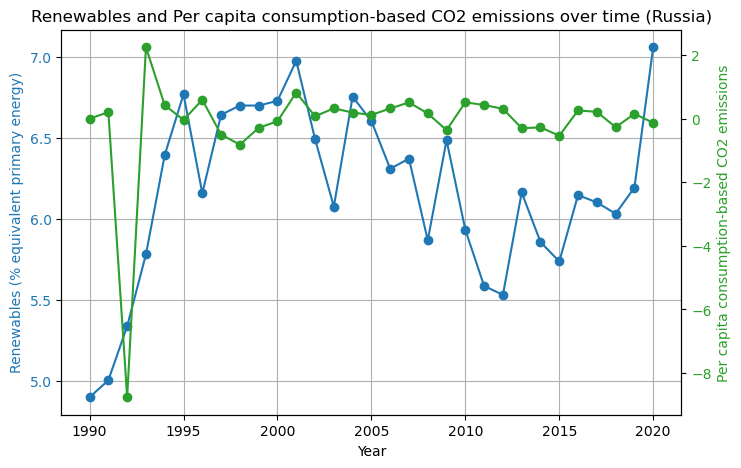

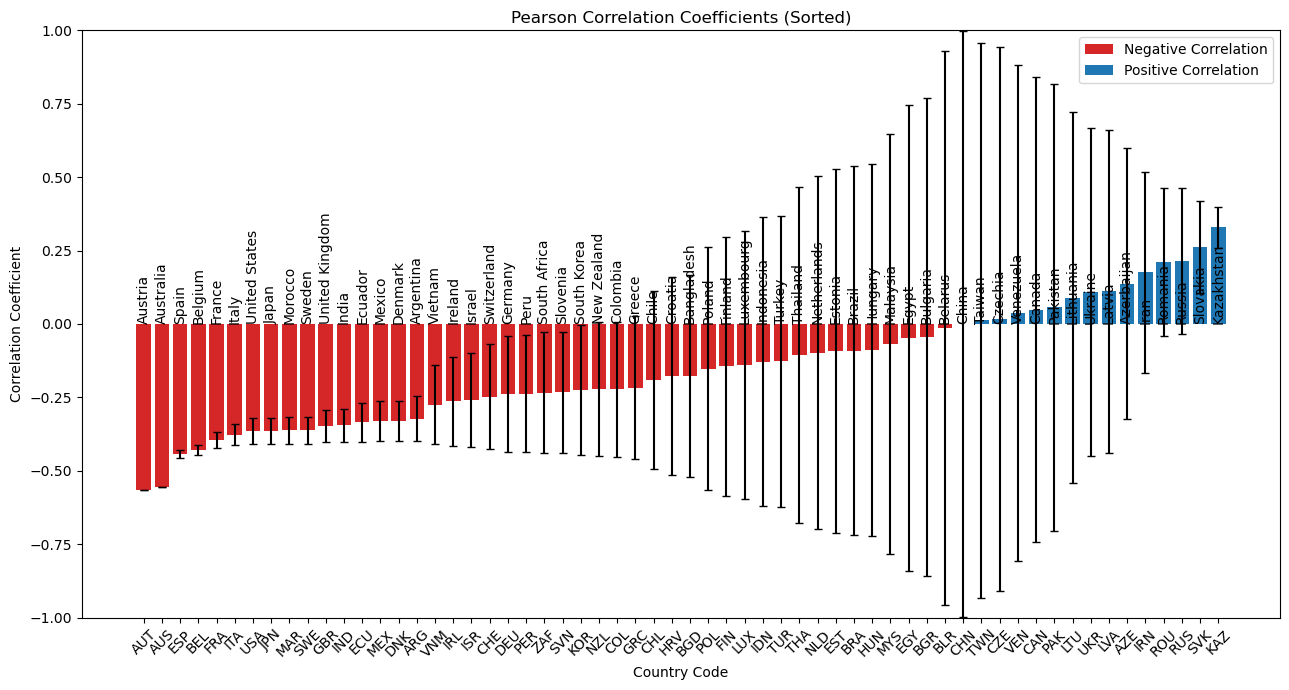

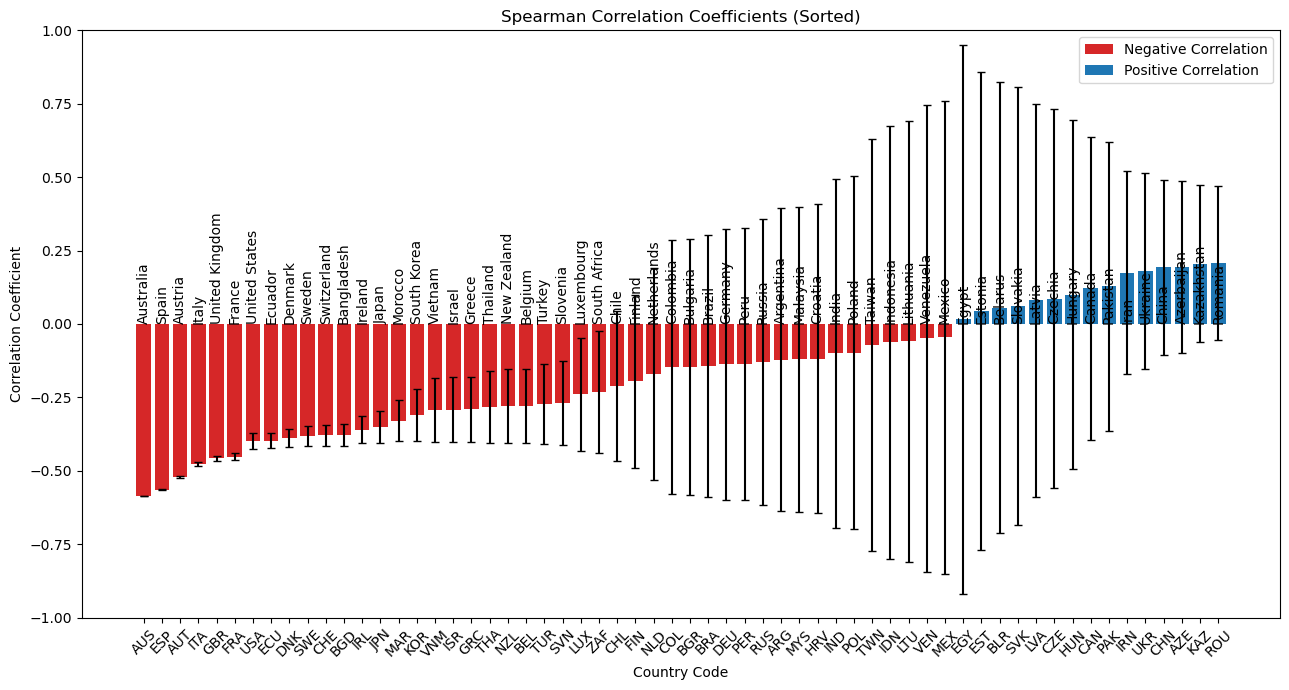

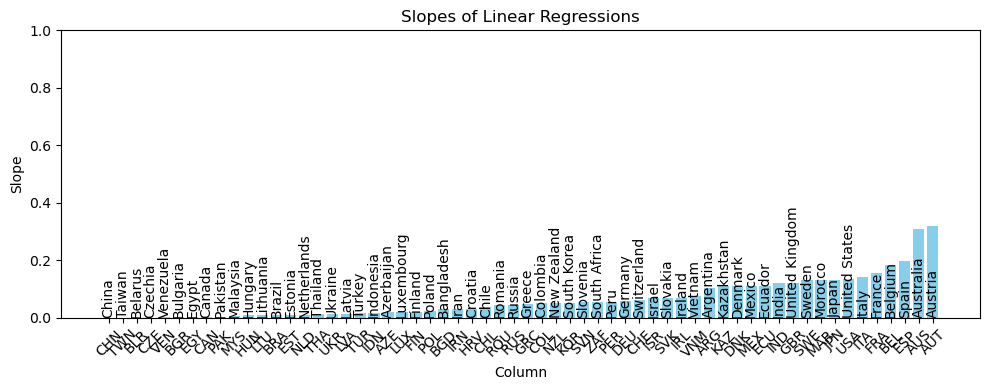


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1626  , p=0.6899  , df_denom=27, df_num=1
ssr based chi2 test:   chi2=0.1807  , p=0.6708  , df=1
likelihood ratio test: chi2=0.1801  , p=0.6713  , df=1
parameter F test:         F=0.1626  , p=0.6899  , df_denom=27, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7079  , p=0.2025  , df_denom=24, df_num=2
ssr based chi2 test:   chi2=4.1275  , p=0.1270  , df=2
likelihood ratio test: chi2=3.8590  , p=0.1452  , df=2
parameter F test:         F=1.7079  , p=0.2025  , df_denom=24, df_num=2
--------------------------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0206  , p=0.8870  , df_denom=27, df_num=1
ssr based chi2 test:   chi2=0.0229  , p=0.8798  , df=1
likelihood ratio test: chi2=0.0229  , p=0.8798  , df=1
parameter F test:         F=0.0206  , p=0.8870  , df_denom=27, df_num=1

Granger Causality
number of lags (no zero) 2
ssr

In [ ]:
detrended_renewables_filtered = detrend_differencing(renewables_filtered)
detrended_co2_filtered = detrend_differencing(co2_filtered)

run_tests(renewables_filtered, detrended_co2_filtered)

# Runnning tests GDP adjusted with detrending

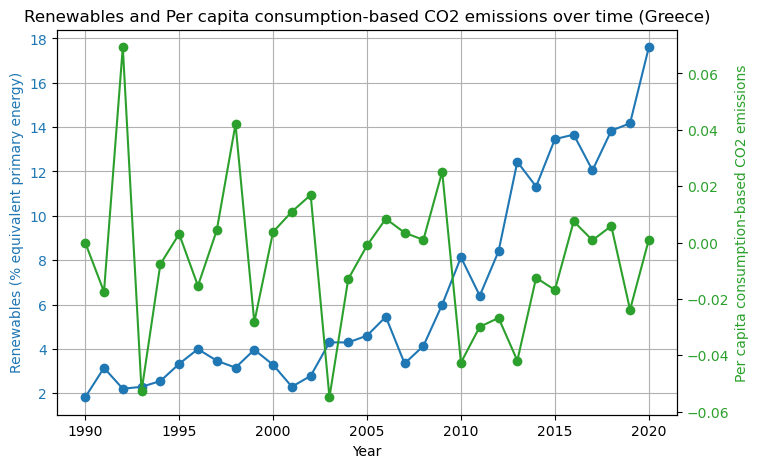

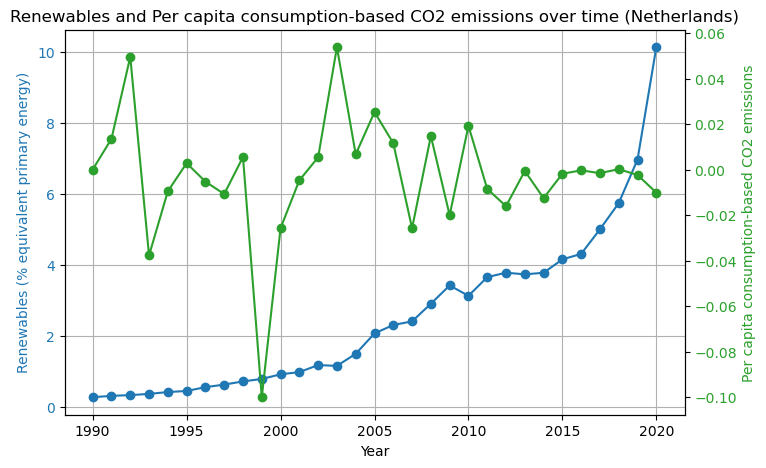

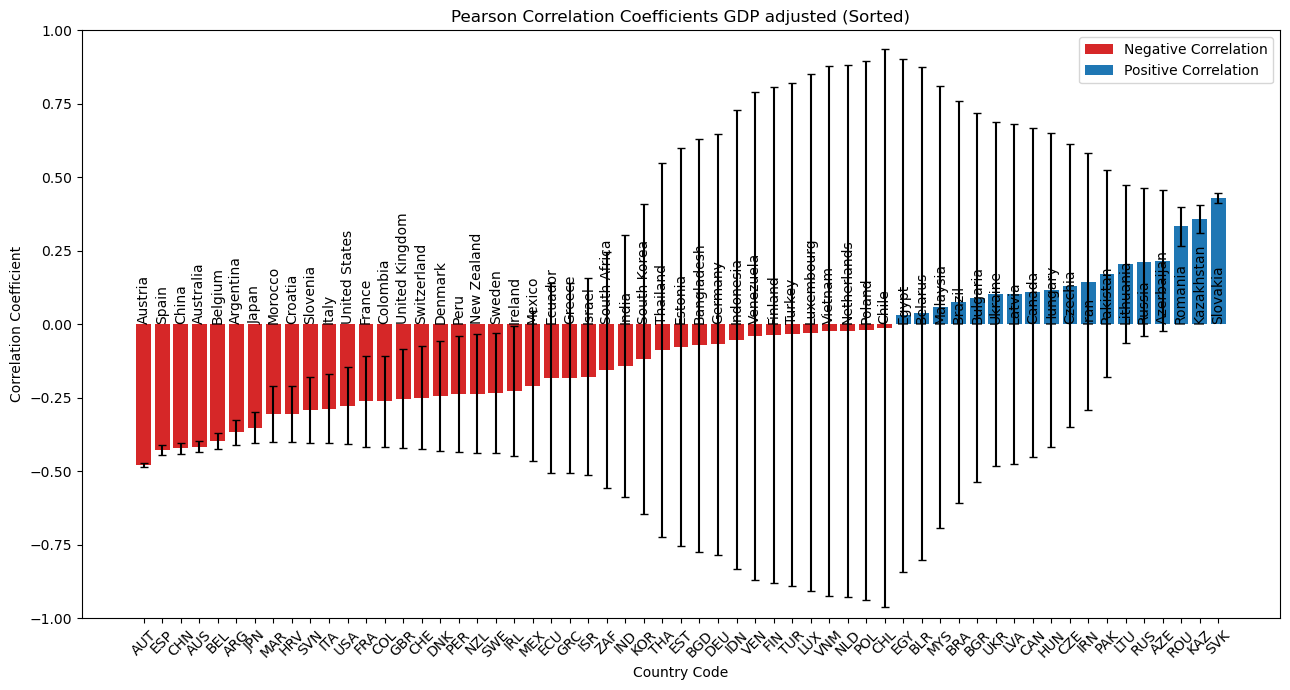

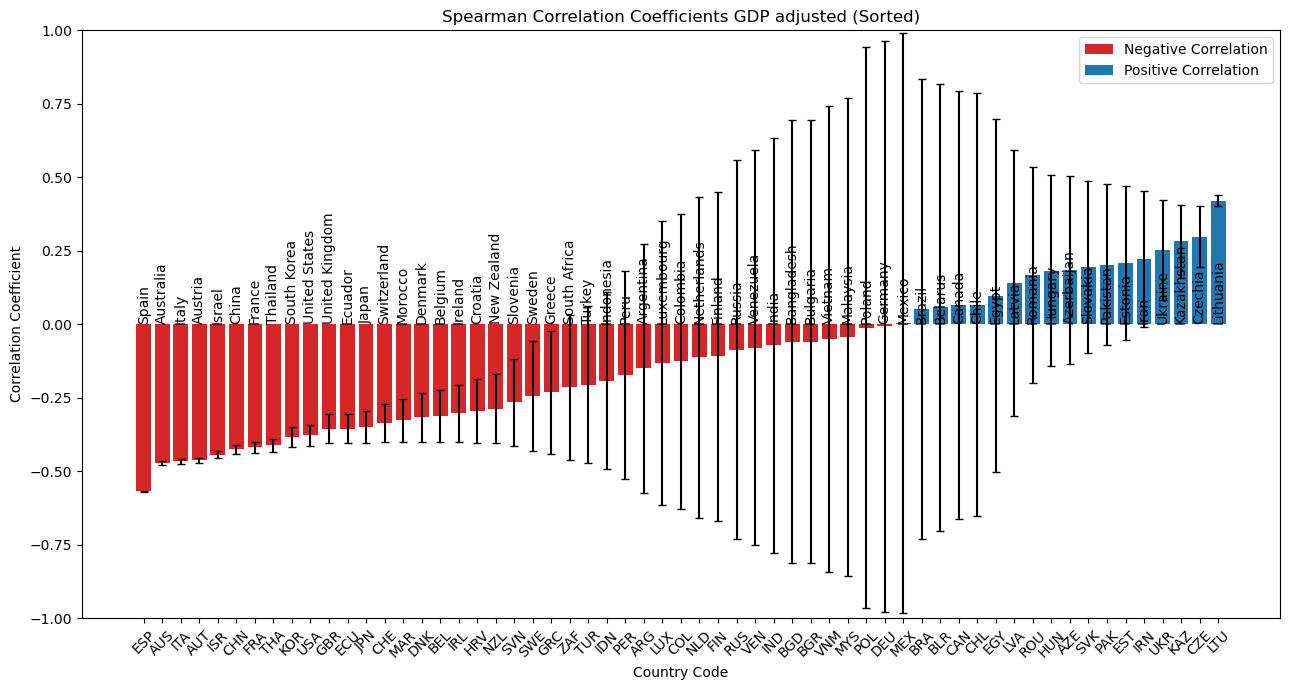

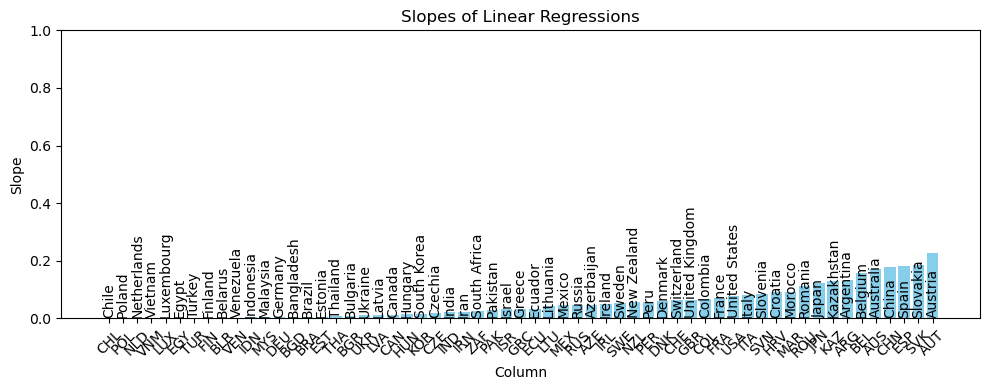


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1450  , p=0.7064  , df_denom=27, df_num=1
ssr based chi2 test:   chi2=0.1611  , p=0.6882  , df=1
likelihood ratio test: chi2=0.1606  , p=0.6886  , df=1
parameter F test:         F=0.1450  , p=0.7064  , df_denom=27, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5640  , p=0.2299  , df_denom=24, df_num=2
ssr based chi2 test:   chi2=3.7796  , p=0.1511  , df=2
likelihood ratio test: chi2=3.5528  , p=0.1692  , df=2
parameter F test:         F=1.5640  , p=0.2299  , df_denom=24, df_num=2
--------------------------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1965  , p=0.6611  , df_denom=27, df_num=1
ssr based chi2 test:   chi2=0.2184  , p=0.6403  , df=1
likelihood ratio test: chi2=0.2176  , p=0.6409  , df=1
parameter F test:         F=0.1965  , p=0.6611  , df_denom=27, df_num=1

Granger Causality
number of lags (no zero) 2
ssr

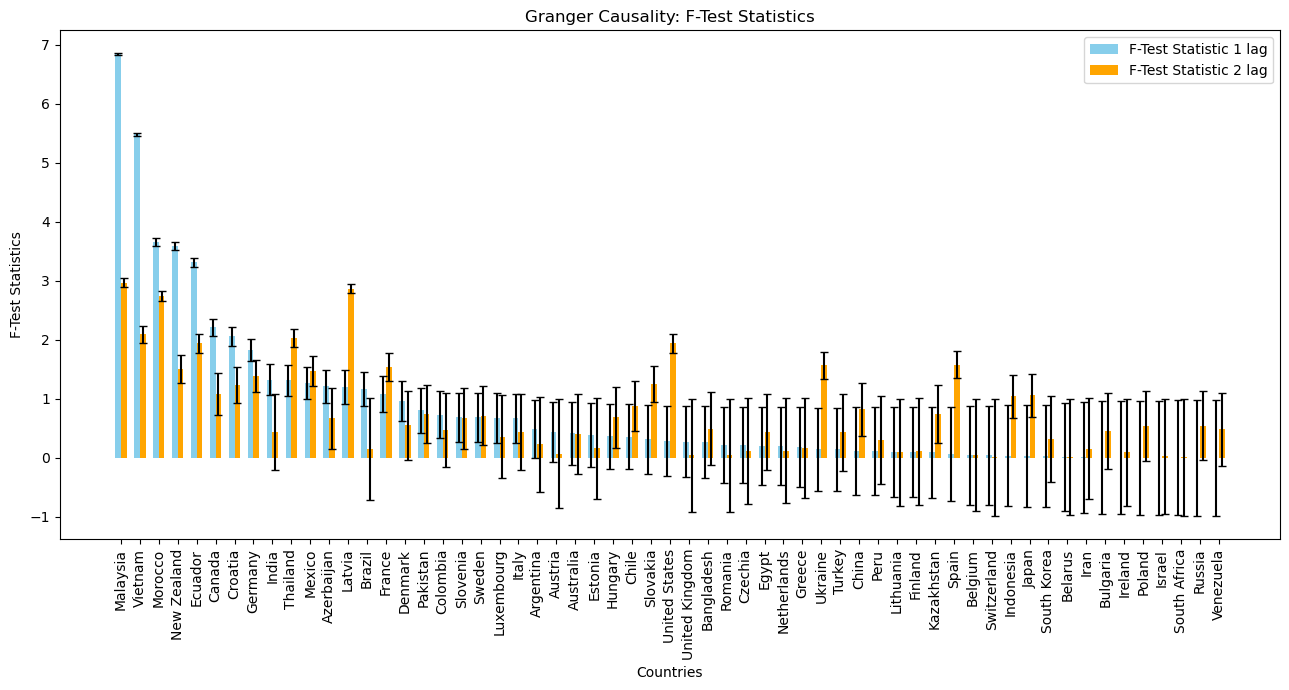

In [ ]:
run_tests_gdp_adjusted(renewables_filtered, detrended_co2_filtered, gdp_filtered)